# Bax Pore (Sequential)
A version of BAX pore assembly where subunits are added to the growing
complex one at a time (contrast with bax_pore.py). Also implements cargo
transport (Smac).

In [1]:
from pysb import *
from pysb.macros import assemble_pore_sequential, pore_transport, pore_species

Model()

# s1,s2 are ring-formation sites; t is the transport (cargo binding) site
Monomer('Bax', ['s1', 's2', 't'])
Annotation(Bax, 'http://identifiers.org/uniprot/Q07812')
# loc is the location, (m)itochondrion or (c)ytosol; t is the transport site
Monomer('Smac', ['loc', 't'], {'loc': ['m','c']})
Annotation(Smac, 'http://identifiers.org/uniprot/Q9NR28')

Parameter('Bax_0', 8e4)
Parameter('Smac_0', 1e5)
for p in Bax_0, Smac_0:
    Annotation(p, 'http://identifiers.org/doi/10.1371/journal.pcbi.1002482',
               'isDescribedBy')

# Start with monomeric Bax and Smac in the mitochondrion
Initial(Bax(s1=None, s2=None, t=None), Bax_0)
Initial(Smac(loc='m', t=None), Smac_0)

# Maximum number of subunits in a pore
max_size = 6
# Size at which pores are "competent" to transport cargo
min_transport_size = 4

# Build handy rate "sets" (in this formulation, rates don't vary with pore size)
assembly_rates = [[2e-4, 1e-3]] * (max_size - 1)
transport_rates = [[3e-5, 1e-3, 1e1]] * (max_size - min_transport_size + 1)

# Assemble the pore
# (specify t=None so the pore can't fall apart while it's bound to cargo)
assemble_pore_sequential(Bax(t=None), 's1', 's2', max_size, assembly_rates)
# Transport Smac
pore_transport(Bax, 's1', 's2', 't', min_transport_size, max_size,
               Smac(loc='m'), 't', Smac(loc='c'), transport_rates)

# Add an observable for each pore size
for size in range(1, max_size + 1):
    Observable('Bax%d' % size, pore_species(Bax, 's1', 's2', size))
# Observe unbound Smac in each compartment
Observable('mSmac', Smac(loc='m', t=None))
Observable('cSmac', Smac(loc='c'))

Observable('cSmac', Smac(loc='c'))

## Simulation

Simulating...


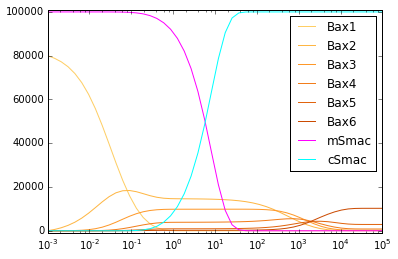

In [3]:
%matplotlib inline
from pylab import *
from pysb.integrate import odesolve

# System is very stiff, and using logspace instead of linspace to produce the
# vector of time points happens to help with the integration
t = logspace(-3, 5) # 1e-3 to 1e5
print "Simulating..."
x = odesolve(model, t)

# Plot trajectory of each pore
for i in range(1, max_size + 1):
    observable = 'Bax%d' % i
    # Map pore size to the central 50% of the YlOrBr color map
    color = cm.YlOrBr(float(i) / max_size / 2 + 0.25)
    plot(t, x[observable], c=color, label=observable)
# Plot Smac species
plot(t, x['mSmac'], c='magenta', label='mSmac')
plot(t, x['cSmac'], c='cyan', label='cSmac')

# Expand the limits a bit to show the min/max levels clearly
ylim([-0.01e5, 1.01e5])
# Show time on a log scale 
xscale('log')
legend(loc='upper right')
show()